In [89]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Missing Data & PCA


**Harvard University**<br/>
**Fall 2023**<br/>
**Instructors**: Pavlos Protopapas & Kevin Rader

---

In [90]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

### Import Libraries

In [91]:
# RUN THIS CELL

# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="contents"></a>

## Notebook contents

- [**PART 1 [45 pts]: Principal Componant Analysis**](#part2)
  - [Question 1: PCA for Regression [35 pts]](#part1q1)
      - [Solutions](#part1q1solution)
  - [Question 2: Visualizing Transformed Data [10 pts]](#part1q2)
      - [Solutions](#part1q2solution)
      
- [**PART 2 [55 pts]: Predicting the selling price of used cars (missing data)**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Question 3: Visualizing Missing Data [10 pts]](#part2q3)
      - [Solutions](#part2q3solution)
  - [Question 4: Imputation Methods [45 pts]](#part2q4)
      - [Solutions](#part2q4solution)




<a id="part1"></a>
    
# PART 1 [45 pts]: Principal Component Analysis

[Return to contents](#contents)

<a id="part2q3"></a>

## <div class='exercise'><b> Question 1: PCA for Regression [35 pts]</b></div>

[Return to contents](#contents)
 

In this question, we will be using a dataset called "Communities and Crime" adapted from [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime). The modified dataset contains 122 predictor variables and 1 response variable. All numeric data was normalized into the decimal range 0.00-1.00. Some of the predictor variables are:

- `householdsize`: mean people per household
- `medIncome`: median household income
- `PctHousOccup`: percent of housing occupied
- `RentMedian`: rental housing - median rent
- `PolicReqPerOffic`: total requests for police per police officer

And the response variable is 

- `ViolentCrimesPerPop`: total number of violent crimes per 100K popuation


In [92]:
# Load the datasets
df = pd.read_csv("data/communities_and_crime.csv", index_col = 0)
df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,...,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.00,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,...,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.10,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.15,0.31,0.40,0.63,0.14,0.06,0.58,0.72,0.65,0.47,0.16,1.00,0.22,0.52,0.10,0.51,0.48,0.39,0.51,0.30,0.29,0.34,0.23,0.13,0.20,...,0.93,0.38,0.05,0.21,0.23,0.30,0.61,0.89,0.15,0.01,0.06,0.12,0.10,0.64,0.22,0.06,0.39,0.84,0.06,0.06,0.91,0.5,0.88,0.26,0.49
2,0.25,0.54,0.05,0.71,0.48,0.30,0.42,0.48,0.28,0.32,0.26,1.00,0.33,0.55,0.37,0.37,0.39,0.64,0.44,0.32,0.29,0.32,0.23,0.17,0.17,...,0.96,0.12,0.05,0.11,0.35,0.08,0.80,0.82,0.04,0.19,0.19,0.18,0.05,0.57,0.36,0.09,0.46,0.05,0.09,0.05,0.88,0.5,0.76,0.13,0.34
3,1.00,0.42,0.47,0.59,0.12,0.05,0.41,0.53,0.34,0.33,1.00,0.99,0.28,0.62,0.16,0.36,0.40,0.30,0.45,0.29,0.30,0.35,0.21,0.20,0.33,...,0.75,0.19,0.35,0.19,0.38,0.16,0.82,0.70,0.45,0.03,0.05,0.33,0.13,0.57,1.00,1.00,0.07,0.15,1.00,0.35,0.73,0.0,0.31,0.21,0.69
4,0.11,0.43,0.04,0.89,0.09,0.06,0.45,0.48,0.31,0.46,0.13,1.00,0.22,0.52,0.44,0.49,0.56,0.41,0.39,0.25,0.25,0.25,0.16,0.07,0.20,...,0.98,0.14,0.03,0.14,0.37,0.11,0.84,0.96,0.00,0.00,0.00,0.00,0.02,0.86,0.29,0.16,0.12,0.07,0.04,0.01,0.81,1.0,0.56,0.09,0.63


In [93]:
# Separate predictors and response
X, y = df.drop(columns=['ViolentCrimesPerPop']), df['ViolentCrimesPerPop']
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="part2q3solution"></a>
## Question 1: Solutions 

[Return to contents](#contents)

<div class='exercise-r'>

**1.1** Compute the correlation matrix for the predictor variables in the training data (DO NOT print the entire matrix). Which pairs of distinct predictor variables have correlation greater than 0.99 or less than -0.99? 
    
Store these pairs in a dictionary called `high_corr` where the keys are tuples corresponding to the names of the pair of predictors and the values are the correlation between each pair.

**Hint:** A simple method for finding the correlation matrix was demonstrated in the lab on PCA.
</div>

In [94]:
# your code here
X_cor = X_train.corr().abs()
corr_condition = X_cor[(X_cor>.99)]

indices = np.where(corr_condition.values < 1)
index_tup = [] 
for i in range(len(indices[0])):
    s = sorted([indices[0][i], indices[1][i]])
    # print(f'{i}: ', s)
    index_tup.append(tuple(s))
    
corr_preds = list(set(index_tup))
high_corr= {}
for i in corr_preds:
    predictors = (X_cor.columns[i[1]], X_cor.columns[i[0]])
    corr = X_train.corr().iloc[i[0], i[1]]
    high_corr[predictors] = corr

print("The following pairs of predictor variables have correlation greater than 0.99 or less than -0.99:")
display(high_corr)

The following pairs of predictor variables have correlation greater than 0.99 or less than -0.99:


{('PctRecImmig10', 'PctRecImmig5'): 0.9900961766413996,
 ('numbUrban', 'population'): 0.9997647561886096,
 ('PctRecImmig10', 'PctRecImmig8'): 0.9965871515033231,
 ('PctRecImmig8', 'PctRecImmig5'): 0.9963359613654262,
 ('PolicPerPop', 'LemasSwFTPerPop'): 0.9999911313418828,
 ('OwnOccMedVal', 'OwnOccLowQuart'): 0.9917227618576423,
 ('PctRecImmig5', 'PctRecentImmig'): 0.9920034327871089,
 ('MedRent', 'RentMedian'): 0.9930215184921779,
 ('LemasSwFTFieldOps', 'LemasSwornFT'): -0.990313653958998}

In [95]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.2** Fit a linear regression model on the **unscaled** training data **using all available predictors**. Store the train and test $R^2$ scores in `linreg_train_r2` and `linreg_test_r2` respectively. Interpret your results.
    
</div>

The test score r^2 is much lower than the r^2 of the train score. This suggests overfitting to the training set because of how poorly it generalized when applied to unseen data.

In [96]:
# your code here
lr = LinearRegression()
lr.fit(X_train, y_train)
linreg_train_r2 = lr.score(X_train,y_train)
linreg_test_r2 = lr.score(X_test,y_test)
print(f"linear regression train R^2: {linreg_train_r2:.4f}")
print(f"linear regression test R^2: {linreg_test_r2:.4f}")

linear regression train R^2: 0.8461
linear regression test R^2: 0.2186


In [97]:
grader.check("q1.2")

q1.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>


**1.3.1** Standardize both **X_train** and **X_test**, *fitting the scaler on all the data*, and for each number of components $k$ in $k \in \{1,2,3,4,5,6,8,10,12,15,20\}$: 

  - Fit the PCA transformation with n_components = $k$ on the standardized **X_train**.
    
  - Apply the PCA transformation to the standardized **X_train**.
    
  - Use scikit-learn's cross_validate(...) to perform a 10-fold cross validation for a linear regression model on the transformed training data. 
    
  Plot the mean validation MSE for each $k$. Store the best $k$ based on the mean validation MSE as `best_k`.
    
</div>

The best k is 8.


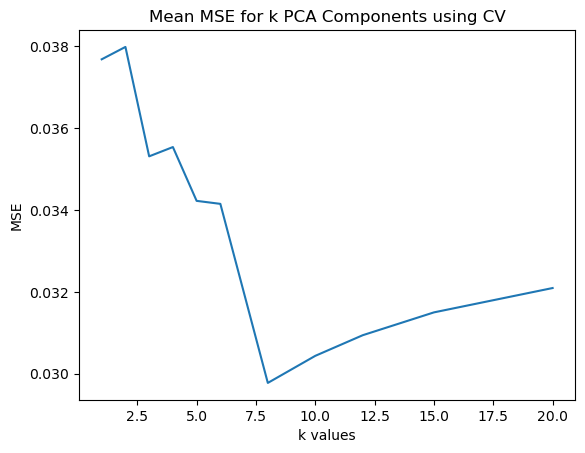

In [98]:
# your code here
ks = [1,2,3,4,5,6,8,10,12,15,20]
scalar = StandardScaler()

all_data = pd.concat([X_train, X_test])
scalar.fit(all_data)
X_std_train = scalar.transform(X_train)
X_std_test = scalar.transform(X_test)

cv_scores = []
for k in ks:
    pca = PCA(k).fit(X_std_train)
    X_pca_train = pca.transform(X_std_train)
    scores = cross_validate(LinearRegression(), X_pca_train,y_train,cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(-np.mean(scores['test_score']))

plt.plot(ks, cv_scores)
plt.xlabel('k values')
plt.ylabel('MSE')
plt.title('Mean MSE for k PCA Components using CV')

best_k = ks[cv_scores.index(min(cv_scores))]
print(f"The best k is {best_k}.")

In [99]:
grader.check("q1.3.1")

q1.3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>
    

**1.3.2** Now let's compute the $R^2$ value on the testing data:
  - Fit the PCA transformation on the standardized **X_train** with n_components equal to the best $k$ above.
  - Apply the PCA transformation to the standardized **X_train** and the standardized **X_test**. 
  - Fit a linear regression model to the PCA-transformed components. Store the train and test $R^2$ scores in `pcr_train_r2` and `pcr_test_r2` respectively.
    
</div>

In [100]:
# your code here
pca = PCA(n_components=best_k).fit(X_std_train)
X_pca_train = pca.transform(X_std_train)
X_pca_test = pca.transform(X_std_test)

lr = LinearRegression().fit(X_pca_train, y_train)

pcr_train_r2 = lr.score(X_pca_train,y_train)
pcr_test_r2 = lr.score(X_pca_test, y_test)
print(f"PCR train R^2: {pcr_train_r2:.4f}")
print(f"PCR test R^2: {pcr_test_r2:.4f}")

PCR train R^2: 0.6377
PCR test R^2: 0.6858


In [101]:
grader.check("q1.3.2")

q1.3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.4** Compare the $R^2$ value obtained from **3.2** (original predictors) and **3.3.2** (PCR). Provide an explanation for the observed difference in these results.
    
</div>

In [102]:
# Display your results
pd.DataFrame([
    {'model': 'linear regression (original predictors)',
     'train $R^2$': linreg_train_r2,
     'test $R^2$': linreg_test_r2},
    {'model': f'PCR (k={best_k})',
     'train $R^2$': pcr_train_r2,
     'test $R^2$': pcr_test_r2},
]).set_index('model')

,train $R^2$,test $R^2$
model,,
linear regression (original predictors),0.846,0.219
PCR (k=8),0.638,0.686


The model using linear regression model resulted in high a high r^2 train score but very poor test score while the PCR model resulted in very consistent results for both train and test while performing worse than the train set using the original predictors. PCA in theory finds the linear combination of predictors that explains the most variance. Due to the unsupervised nature, it might not pick the best components to predict the response variable explaining the lower train score, however, this model generalizes for unseen data much better than the original model. This is because pca reduces the dimensionality, and overfitting caused by the excessively large number of predictors in the original model.

<!-- END QUESTION -->

<a id="part1q2"></a>

## <div class='exercise'><b> Question 2: Visualizing Transformed Data [10 pts]</b></div>

[Return to contents](#contents)

In this question, we will be using a dataset called "Better Life Index" adapted from [Organisation for Economic Co-operation and Development](https://stats.oecd.org/). The modified dataset contains 24 numerical variables and 1 categorical variable. The categorical variable `Country` is the name of the country. Some of the numerical variables include:

- `Dwellings without basic facilities`
- `Housing expenditure`
- `Rooms per person`
- `Household net adjusted disposable income`
- `Household net financial wealth`
- ...

In [103]:
# Load and inspect the datasets
df = pd.read_csv("data/OECD_well-being.csv", index_col = 0)
print('df shape:', df.shape)
df.head()

df shape: (38, 25)


,Country,Dwellings without basic facilities,Housing expenditure,Rooms per person,Household net adjusted disposable income,Household net financial wealth,Labour market insecurity,Employment rate,Long-term unemployment rate,Personal earnings,Quality of support network,Educational attainment,Student skills,Years in education,Air pollution,Water quality,Stakeholder engagement for developing regulations,Voter turnout,Life expectancy,Self-reported health,Life satisfaction,Feeling safe walking alone at night,Homicide rate,Employees working very long hours,Time devoted to leisure and personal care
0,Australia,1.1,20,2.3,33417,57462,4.3,72,1.36,52063,94,80,502,21.2,5,92,2.7,91,82.5,85,7.3,63.6,1.0,13.20,14.35
1,Austria,1.0,21,1.6,32544,59574,2.7,72,1.94,48295,92,85,492,17.1,16,93,1.3,75,81.3,70,7.0,80.7,0.4,6.78,14.55
2,Belgium,2.3,21,2.2,29968,104084,4.8,62,3.98,49587,92,75,503,18.2,15,84,2.2,89,81.1,75,6.9,70.7,1.0,4.31,15.77
3,Canada,0.2,22,2.5,29850,85758,3.9,73,0.81,48403,93,91,523,16.7,7,91,3.0,68,81.5,88,7.3,80.9,1.4,3.73,14.41
4,Chile,9.4,18,1.9,16588,21409,8.1,62,2.02,28434,84,65,443,17.3,16,69,1.5,49,79.1,57,6.7,51.1,4.5,10.06,14.90


In [104]:
# Separate predictors and response
country, X = df['Country'], df.drop(columns='Country').values

<div class='exercise-r'>

**2.1** Standardize **X** and apply a PCA transformation with n_components = 2 to your standardized data. Save the transformed data as `X_transformed`.
    
</div>


In [105]:
scalar = StandardScaler().fit(X=X)
X_std = scalar.transform(X)
pca = PCA(n_components=2)
X_transformed = pca.fit(X_std).transform(X_std)

In [106]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.2** Make a scatter plot for the transformed data, where the x-axis corresponds to the first principal component, and the y-axis corresponds to the second principal component. The plot should state the amount of variance explained by each component. 

Label each point by its corresponding country name. Do you observe any pattern in the scatter plot? Be specific and explain.
    
</div>

In this plot, I can distinguish a couple different groups of similar countries in terms of continent, general wealth/safety, and level of development. Keeping in mind, these 2 components only only a little over 50% of this data's variance, the farthest most clusters are largerly western European countries with the addition on Australia and New Zealand. These are many of the weathliest, safest and most developed countries in the world. From the center, countries in the other directions include Latin America/Africa or Eastern Europe and Asia.

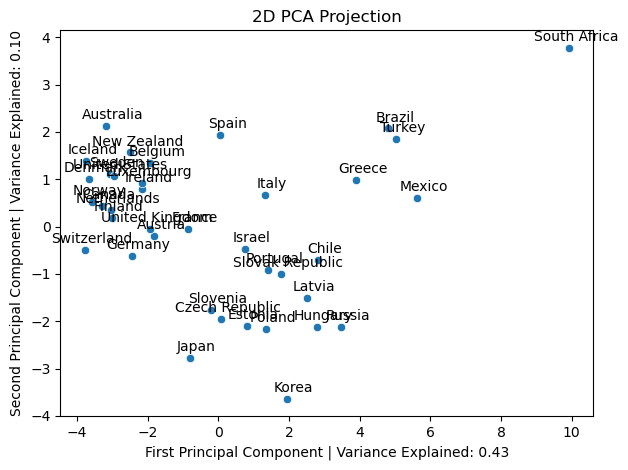

In [107]:
sns.scatterplot(x=X_transformed[:,0], y=X_transformed[:,1])
for i, c in enumerate(country):
    plt.annotate(c, (X_transformed[i,0], X_transformed[i,1]), textcoords='offset points', ha='center', xytext=(5,5),
                 )
plt.xlabel(f'First Principal Component | Variance Explained: {pca.explained_variance_ratio_[0]:.2f}')
plt.ylabel(f'Second Principal Component | Variance Explained: {pca.explained_variance_ratio_[1]:.2f}')
plt.title('2D PCA Projection')
plt.tight_layout()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.3** In question 1, where we also used PCA, we had a training and a test set. In question 2 we did not split the data. Explain why.
    
</div>

The goal of question 2 was not to predict on unseen data but rather explain the variance in the data. It is instead used in question 2's case to understand the data, so more data is better. THe goal of question 1 was to make a generalizeable model, in that case, data should be split to reserve unseen data for testing the model created using the training data.

<!-- END QUESTION -->

<a id="part2"></a>
    
# PART 2 [55 pts]: Predicting the selling price of used cars (missing data)

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description 

[Return to contents](#contents)

In this part, we analyze the data about used cars from a [Kaggle project](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho). The dataset is pre-processed and modified so that it contains missing values. The goal is to handle missing data and predict selling prices from the other features available in this dataset.

### Dataset 

The training dataset is available as `data/vehicle_dataset_train.csv`. It contains the following columns:

- `year` - year of the car when it was bought, 
- `mileage` - mileage of the car,
- `max_power` - maximum power of the engine (in bhps),
- `selling_price` - price at which the car is being sold (in lakh rupees)

The testing dataset is available as `data/vehicle_dataset_test.csv`. It contains all columns mentioned above.


### Objective

We will handle missing data and predict `selling_price` from the other features available in this dataset.

<a id="part1q1"></a>

## <div class='exercise'><b>Question 3: Visualizing Missing Data [10 pts]</b></div>

[Return to contents](#contents)

**PLEASE NOTE:** In this course, you will be expected to ALWAYS label your axes, title your graphs, and produce visuals which clearly communicate the data (as described in the [Instructions](#instructions) at the start of this notebook). Visuals should often be accompanied by text identifying the key point of the visual and defending any choices you make as a data scientist regarding the visual to best communicate your data.

In [108]:
# Load the datasets
df_train = pd.read_csv("data/vehicle_dataset_train.csv", index_col=0)
df_test = pd.read_csv("data/vehicle_dataset_test.csv", index_col=0)
df_train.head(5)

,year,mileage,max_power,selling_price
6601,2015,17.40,117.30,70.0
504,2017,13.60,NaN,262.5
5812,2018,24.00,73.97,71.0
1443,2009,19.70,46.30,15.0
7453,2014,16.02,NaN,42.5


In [109]:
# Separate predictors from responsess
X_train, y_train = df_train.drop(columns=['selling_price']), df_train['selling_price']
X_test, y_test = df_test.drop(columns=['selling_price']), df_test['selling_price']
X_train.shape

(383, 3)

<div class='exercise-r'>

**Q3.1** Let's explore the extent of the missingness in the train data:

- store the number of rows with missing values in `n_rows_with_missingness`
- store the number of columns with missing values in `n_columns_with_missingness`
- Create a Pandas Series where the indices are the column names of `X_train` and the values are the number of missing data entries in the corresponding column in `X_train`. Store this series in `col_missingness`

**Hint:** The Pandas `isna()` method is very helpful. Keep in mind that, when doing arithmetic with boolean values, `True` evaluates to `1` and `False` evaluates to `0`. With this knowledge, how might you use methods like `sum()` and `max()` along specific axes of a data matrix to answer questions about missingness?
</div> 

In [110]:
# counting number of missing rows by creating df of bool values summing .isna() across each row
# them summing that returned df. here is another option X_train.isna().sum().max()
n_rows_with_missingness = X_train.isna().sum(axis=1).sum()
# .isna() returns bool for every value in df for whether data is missing
# .any() evaluates each row return bool if there are any true bools in columns then summing that returned series
n_cols_with_missingness = X_train.isna().any().sum()
col_missingness = X_train.isna().sum()


In [111]:
# display your results with this code
print('# rows with missingness:', n_rows_with_missingness)
print('# columns with missingness:', n_cols_with_missingness)
print(f'\ncolumns with missingness:\n{col_missingness}')

# rows with missingness: 44
# columns with missingness: 1

columns with missingness:
year          0
mileage       0
max_power    44
dtype: int64


In [112]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2** Generate a boxplot of `year` for all samples that have missing values. In the same plot, generate another boxplot of `year` for all samples that do not have missing values. Do you see any pattern?  If so, what might be the implications of that pattern? 

</div> 

The median and IQR year of the boxplot with missing data is higher than the boxplot of year without missing data suggesting the rows with missing data are of more recent cars. Considering the dataset, this encourages me to look into the relationship between fuel type of the car with missing max_power since the pattern must be related to the popularization of electric cars which sometimes don't measure power in bhps. This is a specific example but in summary, I would look deeper in the data to see if this pattern can be explain elsewhere

Text(0.5, 0.98, 'Boxplots Evaluating Year With/Without Missing Data')

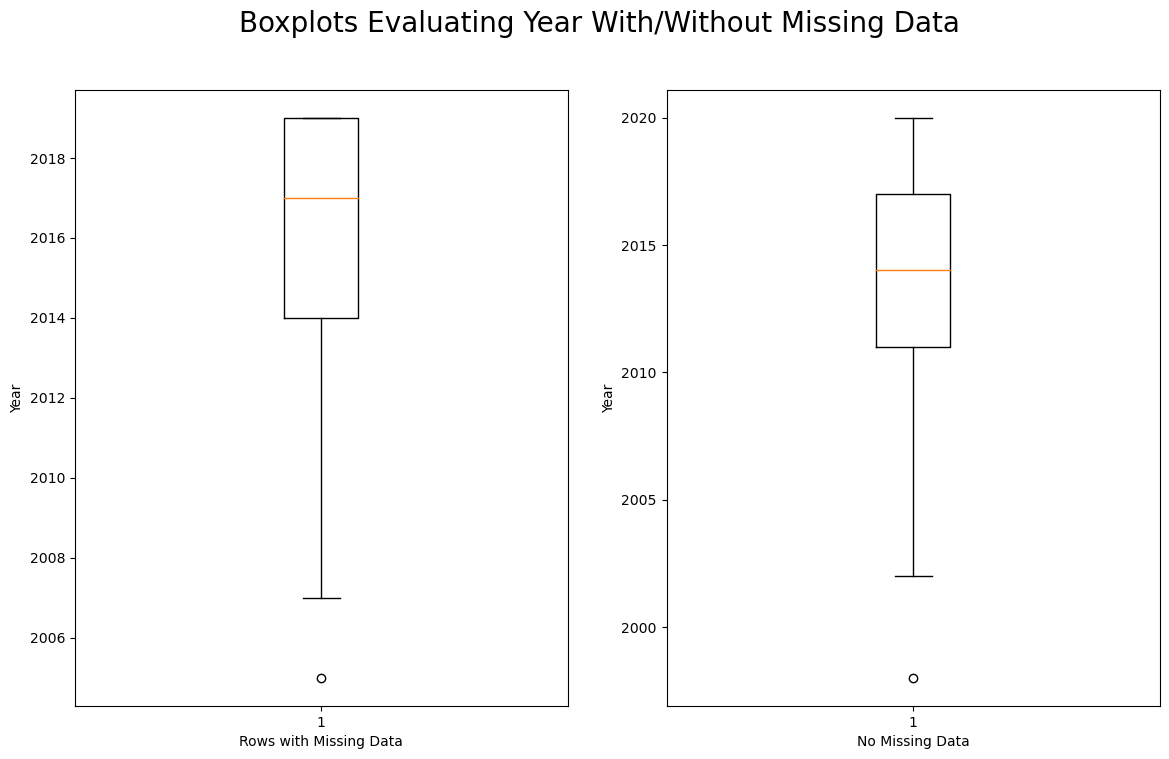

In [113]:
# your code here
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].boxplot(X_train[X_train.isna().any(axis=1)].year)
axs[0].set_xlabel('Rows with Missing Data')
axs[0].set_ylabel('Year')

axs[1].boxplot(X_train.dropna().year)
axs[1].set_xlabel('No Missing Data')
axs[1].set_ylabel('Year')

fig.suptitle('Boxplots Evaluating Year With/Without Missing Data', fontsize= 20)

<!-- END QUESTION -->

<a id="part1q2"></a>

## <div class='exercise'><b> Question 4:   Imputation Methods [45 pts]</b></div>

[Return to contents](#contents)

We will try different ways of dealing with missing data. Take care not to overwrite the original `X_train` and `X_test` as we'll want to use them each time we try a new imputation method.

<div class='exercise-r'>

    

**4.1** First, we consider mean imputation:
  - Use SimpleImputer to impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**. 
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_meanimp_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_meanimp_r2` 
    
**NOTE:** For the sake of consistency, we will used standardized data throughout question 2 (consider why this is necessary for at least some of our models and imputation methods). Note that we are fitting our scaler on *all* the data (train + test).
    
</div>

In [114]:
scaler = StandardScaler().fit(np.concatenate([X_train.values, X_test.values], axis=0))
X_train_scaled = scaler.transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)
# Add back column names lost during scaling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [115]:
# your code here
impute_mean = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X_train_scaled)
x_train_imputed = impute_mean.transform(X_train_scaled)
x_test_imputed = impute_mean.transform(X_test_scaled)

lr = LinearRegression().fit(x_train_imputed, y_train)
linreg_meanimp_r2 = lr.score(x_test_imputed, y_test)

knn = KNeighborsRegressor(n_neighbors=2).fit(x_train_imputed, y_train)
knn_meanimp_r2 = knn.score(x_test_imputed, y_test)



In [116]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<div class='exercise-r'>

**4.2** Now, we will impute the data using k-NN regression model and see how it works:
  - Use KNNImputer ($k$=2) to impute both **X_train** and **X_test**.
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_knnimp_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_knnimp_r2` 
</div>

In [117]:
# your code here
knn_imputer = KNNImputer(n_neighbors=2).fit(X_train_scaled)
x_train_knnimputer = knn_imputer.transform(X_train_scaled)
x_test_knnimputer = knn_imputer.transform(X_test_scaled)

lr_knnimp = LinearRegression().fit(x_train_knnimputer, y_train)
linreg_knnimp_r2 = lr_knnimp.score(x_test_knnimputer, y_test)

knn_knnimp = KNeighborsRegressor(n_neighbors=2).fit(x_train_knnimputer, y_train)
knn_knnimp_r2 = knn_knnimp.score(x_test_knnimputer, y_test)
print(knn_knnimp_r2)

0.6214737447666816


In [118]:
grader.check("q4.2")

q4.2 results:
    q4.2 - 1 result:
        ✅ Test case passed

    q4.2 - 2 result:
        ✅ Test case passed

    q4.2 - 3 result:
        ✅ Test case passed

    q4.2 - 4 result:
        ❌ Test case failed
        Trying:
            assert round(knn_knnimp_r2, 3) == 0.622 ,\
            "The true knn_knnimp_r2 is between 0.622"
        Expecting nothing
        **********************************************************************
        Line 2, in q4.2 3
        Failed example:
            assert round(knn_knnimp_r2, 3) == 0.622 ,\
            "The true knn_knnimp_r2 is between 0.622"
        Exception raised:
            Traceback (most recent call last):
              File "c:\Users\gw1053760\micromamba\envs\cs109a\Lib\doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4.2 3[0]>", line 1, in <module>
                assert round(knn_knnimp_r2, 3) == 0.622 ,\
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: The true knn_knnimp_r2 is between 0.622

<div class='exercise-r'>

    
**4.3** Now, let's examine the indicator method:
  - For both the training and testing data, create an additional predictor called `has_missing_value` that indicates whether each row has any missing value.
  - Impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**.
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_indic_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_indic_r2` 
    
</div>

In [119]:
X_train.iloc[0,:].isna().sum()
# .sum(axis=1).iloc[2]

0

In [120]:
# your code here
def has_missing_value(row):
    # print(row)
    missing = row.isna().sum()
    return missing

X_train_missing_col = X_train_scaled.copy()
X_test_missing_col = X_test_scaled.copy()

X_train_missing_col['missing_value'] = X_train_scaled.apply(has_missing_value, axis=1)
X_test_missing_col['missing_value'] = X_test_scaled.apply(has_missing_value, axis=1)

In [127]:
impute_mean_missingcol = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X_train_missing_col)
X_train_missingimp = impute_mean_missingcol.transform(X_train_missing_col)
X_test_missingimp = impute_mean_missingcol.transform(X_test_missing_col)


lr_missingcol = LinearRegression().fit(X_train_missingimp, y_train)
linreg_indic_r2 = lr_missingcol.score(X_test_missingimp, y_test)

knn_missingcol = KNeighborsRegressor(n_neighbors=2).fit(X_train_missingimp, y_train)
knn_indic_r2 = knn_missingcol.score(X_test_missingimp, y_test)

knn_indic_r2

0.6690642717448874

In [128]:
grader.check("q4.3")

q4.3 results:
    q4.3 - 1 result:
        ✅ Test case passed

    q4.3 - 2 result:
        ✅ Test case passed

    q4.3 - 3 result:
        ✅ Test case passed

    q4.3 - 4 result:
        ❌ Test case failed
        Trying:
            assert round(knn_indic_r2, 3) == 0.653 ,\
            "The true knn_indic_r2 is between ~0.653"
        Expecting nothing
        **********************************************************************
        Line 2, in q4.3 3
        Failed example:
            assert round(knn_indic_r2, 3) == 0.653 ,\
            "The true knn_indic_r2 is between ~0.653"
        Exception raised:
            Traceback (most recent call last):
              File "c:\Users\gw1053760\micromamba\envs\cs109a\Lib\doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4.3 3[0]>", line 1, in <module>
                assert round(knn_indic_r2, 3) == 0.653 ,\
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: The true knn_indic_r2 is between ~0.653

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.4** Compare the $R^2$ values from **4.1 - 4.3**. Does adding an indicator variable help? Do these indicator method results provide any support **for** or **against** a claim that the data is missing completely at random? Why or why not?
    
</div>

In [129]:
# Display your results
pd.DataFrame([
    {'missingness approach': 'mean imputation',
     'linreg test $R^2$': linreg_meanimp_r2,
     'knn test $R^2$': knn_meanimp_r2},
    {'missingness approach': 'knn imputation',
     'linreg test $R^2$': linreg_knnimp_r2,
     'knn test $R^2$': knn_knnimp_r2},
    {'missingness approach': 'missingness indicator + mean imputation',
     'linreg test $R^2$': linreg_indic_r2,
     'knn test $R^2$': knn_indic_r2}, 
]).set_index('missingness approach')

,linreg test $R^2$,knn test $R^2$
missingness approach,,
mean imputation,0.189,0.401
knn imputation,0.205,0.621
missingness indicator + mean imputation,0.395,0.669


Adding the missing indicator resulted in improving the both the linreg and knn r^2 score by .2 against the mean imputation model without the indicator. This suggest that there is evidence against the claim that data is missing completely at random. The improved r^2 score with the indicator implies that the indicator provided info that aided the model in predicting the response variable. Given this column only signal that a row contained missing data, we can conclude that there is pattern between the missing values and target variable.

<!-- END QUESTION -->

**This concludes HW4. Thank you!**

[Return to contents](#contents)